In [13]:
import os
from datetime import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import pandas as pd
import seaborn as sns
import talib as ta
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from CNN_Functions import *

In [293]:
df = pd.DataFrame() #Apple
df = pd.read_csv('/Users/rorymurray/Desktop/FYP/Data/BMW.csv', sep =';')
df.columns = ['Ticker','Per','Date','Time','Open','High','Low','Close','Vol']

#Delta
#dal = pd.DataFrame()
#dal = pd.read_csv('/Users/rorymurray/Downloads/DAL.csv', sep =',')
#dal.columns = ['Ticker','Per','Date','Time','Open','High','Low','Close','Vol']

In [294]:
df['DateTime'] = df[['Date','Time']].apply(lambda x : '{}{}'.format(x[0],x[1]), axis=1) # combine columns
df['DateTime'] = pd.to_datetime(df['DateTime'],format = '%Y%m%d%H%M%S')
df.set_index('DateTime', inplace=True)

del df['Date']
del df['Ticker']
del df['Per']
del df['Time']

In [295]:
#Add features 

df['RSI_14'] = ta.RSI(df["Close"],timeperiod=14)
df['RSI_10'] = ta.RSI(df["Close"],timeperiod=10)
df['RSI_6'] = ta.RSI(df["Close"],timeperiod=6)
df['RSI_2'] = ta.RSI(df["Close"],timeperiod=2)
df['MOM_10'] = ta.MOM(df["Close"], timeperiod=10)
df['MOM_8'] = ta.MOM(df["Close"], timeperiod=8)
df['MOM_4'] = ta.MOM(df["Close"], timeperiod=4)
df['ATR_14'] = ta.ATR(df["High"], df["Low"], df["Close"], timeperiod=14)
df['ATR_10'] = ta.ATR(df["High"], df["Low"], df["Close"], timeperiod=10)
df['ATR_6'] = ta.ATR(df["High"], df["Low"], df["Close"], timeperiod=6)
df['VAR'] = ta.VAR(df["Close"], timeperiod=5, nbdev=1)

df['MA_10'] = ta.MA(df["Close"], timeperiod=10, matype=0)
df['MA_30'] = ta.MA(df["Close"], timeperiod=30, matype=0)
df['MA_50'] = ta.MA(df["Close"], timeperiod=50, matype=0)
df['MA_200'] = ta.MA(df["Close"], timeperiod=200, matype=0)

df['MACD'],macdsignal, macdhist = ta.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)

df = df.iloc[200:]

In [296]:
df.head()

,Open,High,Low,Close,Vol,RSI_14,RSI_10,RSI_6,RSI_2,MOM_10,...,MOM_4,ATR_14,ATR_10,ATR_6,VAR,MA_10,MA_30,MA_50,MA_200,MACD
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-07-18 10:30:00,75.52,75.52,74.56,75.37,105260,61.630345,63.053107,64.686331,49.941283,0.98,...,0.83,0.487765,0.517356,0.587565,0.256056,74.858,74.681967,74.49418,69.523885,0.239013
2016-07-18 11:00:00,75.37,75.37,74.59,74.84,39535,52.352531,50.879654,46.986177,18.680742,0.34,...,0.18,0.508639,0.543620,0.619638,0.192696,74.892,74.692967,74.49038,69.563785,0.214258
2016-07-18 11:30:00,74.89,74.98,74.57,74.75,45758,50.949893,49.091369,44.504657,15.405712,0.10,...,-1.10,0.501593,0.530258,0.584698,0.172824,74.902,74.696633,74.49158,69.600285,0.185242
2016-07-18 12:00:00,74.76,74.81,74.46,74.78,40518,51.417148,49.745558,45.652771,24.258202,0.28,...,-0.74,0.490765,0.512232,0.545582,0.106056,74.930,74.700967,74.49558,69.637135,0.162791
2016-07-18 12:30:00,74.78,74.97,74.72,74.81,41353,51.910492,50.452993,46.969320,37.366869,0.35,...,-0.56,0.473568,0.486009,0.496318,0.053800,74.965,74.706967,74.50118,69.675535,0.145739


In [297]:
  def create_labels(df,col_name, window_size=27):
        """
        Data is labeled as per the logic in research paper
        Label code : BUY => 1, SELL => 0, HOLD => 2
        params :
            df => Dataframe with data
            col_name => name of column which should be used to determine strategy
        returns : numpy array with integer codes for labels with
                  size = total-(window_size)+1
        """

   
        row_counter = 0
        total_rows = len(df)
        df["Label"] = 0 #create label col
        Labelcol = df.columns.get_loc('Label')

        print("Calculating labels")


        while row_counter < total_rows:
            if row_counter >= window_size - 1:
                window_begin = row_counter - (window_size - 1)
                window_end = row_counter
                window_middle = (window_begin + window_end) / 2
                window_middle = int(window_middle)
                
                   
                Min = 10000
                min_index = 0
                Max = 0
                max_index = 0
                
                for i in range(window_begin, window_end + 1):
                    price = df.iloc[i][col_name]
                    if price < Min:
                        Min = price
                        min_index = i
                    if price > Max:
                        Max = price
                        max_index = i

                
                if min_index == window_middle:
                    df.iloc[window_middle,Labelcol] = 1
                else:
                    df.iloc[window_middle,Labelcol] = 0

            row_counter = row_counter + 1
            
create_labels(df,'Close')       
df.head()

Calculating labels


,Open,High,Low,Close,Vol,RSI_14,RSI_10,RSI_6,RSI_2,MOM_10,...,ATR_14,ATR_10,ATR_6,VAR,MA_10,MA_30,MA_50,MA_200,MACD,Label
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-07-18 10:30:00,75.52,75.52,74.56,75.37,105260,61.630345,63.053107,64.686331,49.941283,0.98,...,0.487765,0.517356,0.587565,0.256056,74.858,74.681967,74.49418,69.523885,0.239013,0
2016-07-18 11:00:00,75.37,75.37,74.59,74.84,39535,52.352531,50.879654,46.986177,18.680742,0.34,...,0.508639,0.543620,0.619638,0.192696,74.892,74.692967,74.49038,69.563785,0.214258,0
2016-07-18 11:30:00,74.89,74.98,74.57,74.75,45758,50.949893,49.091369,44.504657,15.405712,0.10,...,0.501593,0.530258,0.584698,0.172824,74.902,74.696633,74.49158,69.600285,0.185242,0
2016-07-18 12:00:00,74.76,74.81,74.46,74.78,40518,51.417148,49.745558,45.652771,24.258202,0.28,...,0.490765,0.512232,0.545582,0.106056,74.930,74.700967,74.49558,69.637135,0.162791,0
2016-07-18 12:30:00,74.78,74.97,74.72,74.81,41353,51.910492,50.452993,46.969320,37.366869,0.35,...,0.473568,0.486009,0.496318,0.053800,74.965,74.706967,74.50118,69.675535,0.145739,0


In [416]:
  def newlabels(df,col_name, window_size=27):

   
        row_counter = 0
        total_rows = len(df)
        df["Label"] = 0 #create label col
        Labelcol = df.columns.get_loc('Label')

        print("Calculating labels")


        while row_counter < total_rows:
            if row_counter >= window_size - 1:
                window_begin = row_counter - (window_size - 1)
                window_end = row_counter
                window_middle = (window_begin + window_end) / 2
                window_middle = int(window_middle)
                
                   
                Min = 10000
                min_index = 0
                Max = 0
                max_index = 0
                
                for i in range(window_begin, window_end + 1):
                    price = df.iloc[i][col_name]
                    if price < Min:
                        Min = price
                        min_index = i
                    if price > Max:
                        Max = price
                        max_index = i

                
                if min_index < window_middle and max_index == window_end:
                    df.iloc[window_middle,Labelcol] = 1
                else:
                    df.iloc[window_middle,Labelcol] = 0

            row_counter = row_counter + 1
            
newlabels(df,'Close')       
df.head()

Calculating labels


,Open,High,Low,Close,Vol,RSI_14,RSI_10,RSI_6,RSI_2,MOM_10,...,ATR_14,ATR_10,ATR_6,VAR,MA_10,MA_30,MA_50,MA_200,MACD,Label
DateTime,,,,,,,,,,,,,,,,,,,,,
2016-07-18 10:30:00,75.52,75.52,74.56,75.37,105260,61.630345,63.053107,64.686331,49.941283,0.98,...,0.487765,0.517356,0.587565,0.256056,74.858,74.681967,74.49418,69.523885,0.239013,0
2016-07-18 11:00:00,75.37,75.37,74.59,74.84,39535,52.352531,50.879654,46.986177,18.680742,0.34,...,0.508639,0.543620,0.619638,0.192696,74.892,74.692967,74.49038,69.563785,0.214258,0
2016-07-18 11:30:00,74.89,74.98,74.57,74.75,45758,50.949893,49.091369,44.504657,15.405712,0.10,...,0.501593,0.530258,0.584698,0.172824,74.902,74.696633,74.49158,69.600285,0.185242,0
2016-07-18 12:00:00,74.76,74.81,74.46,74.78,40518,51.417148,49.745558,45.652771,24.258202,0.28,...,0.490765,0.512232,0.545582,0.106056,74.930,74.700967,74.49558,69.637135,0.162791,0
2016-07-18 12:30:00,74.78,74.97,74.72,74.81,41353,51.910492,50.452993,46.969320,37.366869,0.35,...,0.473568,0.486009,0.496318,0.053800,74.965,74.706967,74.50118,69.675535,0.145739,0


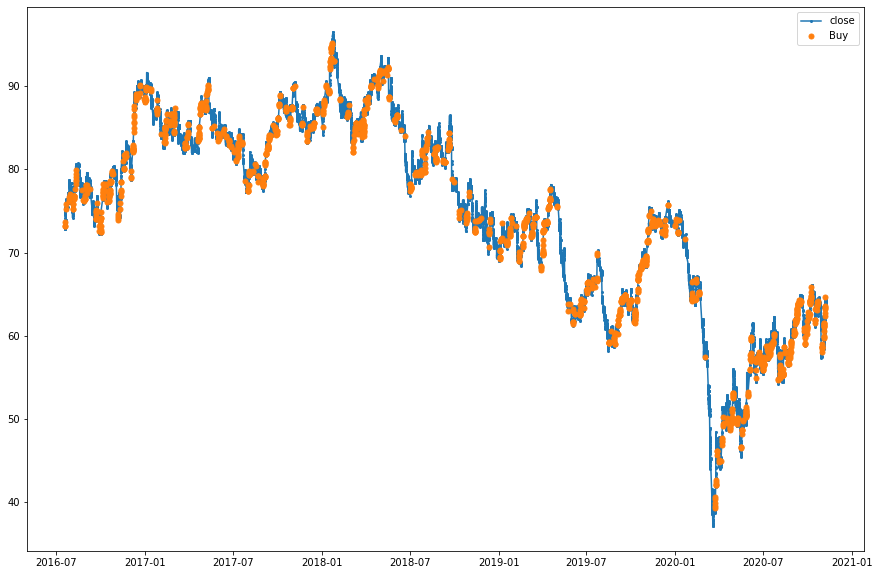

In [418]:
buysignals = df.loc[df['Label'] == 1]


plt.figure(figsize=(15,10))
plt.plot(df['Close'],'o-',label="close",ms = 2)
plt.plot(buysignals['Close'],'o',ms = 5,label = "Buy")
plt.legend()

In [340]:
df.iloc[14400:15100]

,Open,High,Low,Close,Vol,RSI_14,RSI_10,RSI_6,RSI_2,MOM_10,...,ATR_14,ATR_10,ATR_6,VAR,MA_10,MA_30,MA_50,MA_200,MACD,Label
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-11-05 11:00:00,72.55,72.80,72.48,72.65,66566,81.897243,84.206893,87.454096,93.940650,1.10,...,0.320832,0.336627,0.363881,0.213136,71.880,70.898667,70.0280,69.25475,0.665315,0
2019-11-05 11:30:00,72.63,72.88,72.61,72.82,82270,83.151007,85.702662,89.390934,97.149697,1.31,...,0.317201,0.329964,0.348234,0.013480,72.011,71.017333,70.1176,69.27930,0.689659,0
2019-11-05 12:00:00,72.80,72.91,72.77,72.84,67854,83.297567,85.877505,89.617225,97.465524,1.23,...,0.304544,0.310968,0.313528,0.017704,72.134,71.128667,70.2068,69.30480,0.702468,0
2019-11-05 12:30:00,72.84,72.92,72.81,72.88,75323,83.604735,86.251139,90.122855,98.243873,1.52,...,0.290648,0.290871,0.279607,0.018496,72.286,71.245667,70.2988,69.33095,0.707689,0
2019-11-05 13:00:00,72.88,72.93,72.78,72.80,60591,80.419285,81.461794,80.691808,44.086830,1.44,...,0.280602,0.276784,0.258006,0.006176,72.430,71.358000,70.3884,69.35735,0.697333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-09 14:30:00,74.86,74.97,74.81,74.81,33926,60.277648,58.836445,55.038814,50.043640,-0.26,...,0.244780,0.238993,0.222238,0.004720,74.871,74.392000,74.1400,73.87490,0.231024,0
2020-01-09 15:00:00,74.82,74.90,74.80,74.85,23105,61.275848,60.332702,58.011470,64.023484,-0.17,...,0.234438,0.225094,0.201865,0.004896,74.854,74.417333,74.1862,73.87355,0.222846,0
2020-01-09 15:30:00,74.84,74.91,74.81,74.85,19505,61.275848,60.332702,58.011470,64.023484,-0.26,...,0.224835,0.212584,0.184888,0.005280,74.828,74.442333,74.2272,73.87250,0.213900,0


In [346]:
rsi = 0
#14400 , 15100
for i in range(15100,15700):
    rsi = rsi + df.iloc[i,8]
    
a = rsi/600
a

41.09324055844094

In [464]:
df['Label'].value_counts()

0    18386
1     1532
Name: Label, dtype: int64

In [422]:
paperTrade(df,13)

0
Final balance :  118412.89
Final holdings :  0.0
P&L :  18412.89   Gain :  18.412889999999997 %


In [423]:
from sklearn.preprocessing import MinMaxScaler
scaled_df = pd.DataFrame()
scaled_df = df

mm_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = pd.DataFrame(mm_scaler.fit_transform(scaled_df.values), columns=scaled_df.columns, index=scaled_df.index)

In [424]:
def create_images(df, n_steps):
    X, y = list(), list()
    for i in range(len(df)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(df):
            break
        # gather input and output parts of the pattern
        seq_x ,seq_y= df.iloc[i:end_ix, :-1], df.iloc[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

Xtrain,Ytrain = create_images(scaled_df,27)

In [425]:
num = len(Xtrain)*.7 #split 70:30
num = int(num)

Xtest = Xtrain[num:,:]
Ytest = Ytrain[num:]

Xtrain = Xtrain[:num,:]
Ytrain = Ytrain[:num]




In [426]:
Xtrain.shape

(13924, 27, 21)

In [454]:
def build_model():

    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=(6), activation='relu', input_shape=(27,21), padding = 'same'))
    #model.add(MaxPooling1D(pool_size=(2)))
    model.add(Conv1D(filters=32, kernel_size=(6), activation='relu',padding = 'same'))
    model.add(MaxPooling1D(pool_size=(6)))


    #model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1,activation = 'sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'] )
    
    return model




In [455]:
model1 = build_model()

In [456]:
model1.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 27, 16)            2032      
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 27, 32)            3104      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 4, 32)             0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 128)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 129       
Total params: 5,265
Trainable params: 5,265
Non-trainable params: 0
___________________________________________________

In [443]:
unique, counts = np.unique(Ytrain, return_counts=True)
counts

array([12875,  1049])

In [457]:
history = model1.fit(Xtrain,Ytrain,epochs=30,verbose=1,class_weight = {0:0.1,1:0.9})

Epoch 1/30
436/436 [==============================] - 3s 5ms/step - loss: 0.1094 - accuracy: 0.7846
Epoch 2/30
436/436 [==============================] - 2s 5ms/step - loss: 0.1048 - accuracy: 0.7543
Epoch 3/30
436/436 [==============================] - 2s 5ms/step - loss: 0.1020 - accuracy: 0.7479
Epoch 4/30
436/436 [==============================] - 2s 5ms/step - loss: 0.1036 - accuracy: 0.6874
Epoch 5/30
436/436 [==============================] - 2s 5ms/step - loss: 0.1020 - accuracy: 0.7067
Epoch 6/30
436/436 [==============================] - 2s 5ms/step - loss: 0.1031 - accuracy: 0.7000
Epoch 7/30
436/436 [==============================] - 2s 5ms/step - loss: 0.1000 - accuracy: 0.6799: 0s - loss: 0.0999 - ac
Epoch 8/30
436/436 [==============================] - 2s 5ms/step - loss: 0.1012 - accuracy: 0.6796
Epoch 9/30
436/436 [==============================] - 2s 5ms/step - loss: 0.0986 - accuracy: 0.7024
Epoch 10/30
436/436 [==============================] - 2s 5ms/step - loss: 0

In [458]:
results = model1.evaluate(Xtest, Ytest)
print("test loss, test acc:", results)

187/187 [==============================] - 1s 2ms/step - loss: 0.5693 - accuracy: 0.6039
test loss, test acc: [0.5692550539970398, 0.6038873791694641]


In [459]:
predictions = model1.predict(Xtest)

In [460]:
m = predictions.max()
m

0.74860567

In [71]:
num = len(df)*.7 #split 70:30
num = int(num)

a = df.iloc[num-18:num,:]
a



,Open,High,Low,Close,Vol,RSI_14,RSI_10,RSI_6,RSI_2,MOM_10,...,ATR_14,ATR_10,ATR_6,VAR,MA_10,MA_30,MA_50,MA_200,MACD,Label
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-07-24 10:30:00,208.71,209.06,208.48,208.78,63939,69.769409,72.067980,73.984635,72.016408,1.170,...,0.646890,0.644376,0.659534,0.019004,208.2560,207.012833,206.1581,203.851350,0.763365,0
2019-07-24 11:00:00,208.80,209.04,207.79,207.93,59404,56.032905,51.887391,40.828456,9.734417,0.345,...,0.689969,0.704939,0.757945,0.108680,208.2905,207.174000,206.2359,203.879850,0.683747,0
2019-07-24 11:30:00,207.90,208.01,207.57,207.92,41480,55.893481,51.698154,40.571766,9.540282,0.180,...,0.672114,0.678445,0.704954,0.174704,208.3085,207.352000,206.3021,203.910250,0.612777,0
2019-07-24 12:00:00,207.93,208.15,207.74,207.79,33831,54.011944,49.110997,36.947988,6.282613,0.290,...,0.653392,0.651600,0.655795,0.180584,208.3375,207.410000,206.3635,203.943850,0.539821,0
2019-07-24 12:30:00,207.81,208.07,207.78,207.87,24027,55.015509,50.794694,40.849424,34.014118,-0.350,...,0.627435,0.615440,0.594829,0.132776,208.3025,207.466333,206.4241,203.975750,0.482892,0
2019-07-24 13:00:00,207.88,208.22,207.88,208.14,30070,58.321286,56.225813,52.702233,77.985357,-0.020,...,0.607619,0.588896,0.554024,0.013480,208.3005,207.531667,206.4913,204.009025,0.454325,0
2019-07-24 13:30:00,208.19,208.19,207.85,207.85,24435,53.752234,49.681503,41.884602,32.073352,-0.610,...,0.588503,0.564007,0.518354,0.014504,208.2395,207.592333,206.5401,204.044225,0.403631,0
2019-07-24 14:00:00,207.83,207.84,207.31,207.40,35374,47.529750,41.377869,30.302693,11.345043,-1.175,...,0.585038,0.561606,0.521961,0.056520,208.1220,207.630333,206.5759,204.077575,0.323417,0
2019-07-24 14:30:00,207.38,207.50,207.18,207.36,45621,47.008821,40.705921,29.434510,10.175895,-1.480,...,0.566107,0.537445,0.488301,0.089544,207.9740,207.667333,206.6167,204.106925,0.253695,0


In [72]:
Xtest[0,0,1]

209.06

In [461]:
cnn_pred = pd.DataFrame(columns = ['Close', 'Label'])
num = len(df)*.7 #split 70:30
num = int(num)
num = num +8


for i in range(len(Xtest)):
    if num+i < len(df):
        
        if predictions[i] > 0.5:
            cnn_pred = cnn_pred.append({'Close' : df.iloc[num + i,3] , 'Label' : 1}, ignore_index = True)
        
        else:
            cnn_pred = cnn_pred.append({'Close' : df.iloc[num + i,3] , 'Label' : 0}, ignore_index = True)
 

In [462]:
cnn_pred['Label'].value_counts()

0.0    3489
1.0    2479
Name: Label, dtype: int64

In [463]:
paperTrade(cnn_pred,13)

0
Final balance :  101186.55
Final holdings :  0.0
P&L :  1186.550000000003   Gain :  1.1865500000000029 %


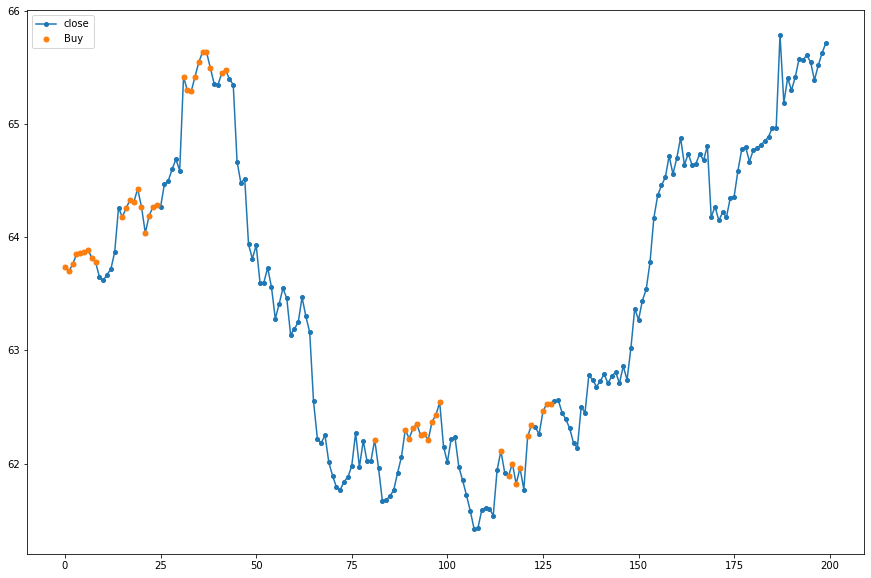

In [468]:
buysignals = cnn_pred.loc[cnn_pred['Label'] == 1]


plt.figure(figsize=(15,10))
plt.plot(cnn_pred['Close'].iloc[:200],'o-',label="close",ms = 4)
plt.plot(buysignals['Close'].iloc[:50],'o',ms = 5,label = "Buy")
plt.legend()